<a href="https://colab.research.google.com/github/jojoroy/MScDis/blob/main/lvmh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# what is the lotka-volterra likelihood
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the Lotka-Volterra equations
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Generate synthetic data using known parameters
def generate_synthetic_data(true_params, initial_conditions, t):
    return odeint(lotka_volterra, initial_conditions, t, args=tuple(true_params))

# Define the likelihood function
def log_likelihood(log_params, t, data, initial_conditions):
    params=np.exp(log_params)
    alpha, beta, delta, gamma = params
    model = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))
    error = data - model
    sigma=np.sqrt(5000)
    return -np.sum(error**2) / (2*sigma**2)

def is_point_in_box(point, box_min, box_max):
    """
    Check if a point is within a box defined by box_min and box_max.

    Parameters:
    point (np.ndarray): The point to check (1D array).
    box_min (np.ndarray): The minimum coordinates of the box (1D array).
    box_max (np.ndarray): The maximum coordinates of the box (1D array).

    Returns:
    bool: True if the point is within the box, False otherwise.
    """
    return np.all(point >= box_min) and np.all(point <= box_max)

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width):
    params = np.array(initial_params)
    log_likelihood_current = log_likelihood(params, t, data, initial_conditions)
    samples = [params]
    q_means=[params]
    q_cov = np.eye(4)*0.25*0.01
    t_0=8#2000
    for i in range(n_iterations):
        # Propose new parameters
        #params_new = params + (np.random.uniform(0,1, size=params.shape)-0.5)*proposal_width
        if i > t_0:
          q_cov=((i-2)/(i-1))*q_cov + ((2.4**2)/(4*(i-1)))*((i-1)*(np.outer(q_means[i-2],q_means[i-2]))-i*np.outer(q_means[i-1],q_means[i-1])+np.outer(samples[i-1],samples[i-1])+ 1e-6*np.eye(4))

        params_new=np.random.multivariate_normal(params,q_cov)
        if is_point_in_box(params_new,[-2,-3,-3,-2],[2,1,1,2]):
          log_likelihood_new = log_likelihood(params_new, t, data, initial_conditions)
        else:
          log_likelihood_new=-10000

        # Acceptance criterion
        if np.log(np.random.rand()) < log_likelihood_new - log_likelihood_current:
            params = params_new
            log_likelihood_current = log_likelihood_new
        if i%1000==0:
          print(i)
        q_mean = q_means[i-1] + (params-q_means[i-1])/(i+1)
        samples.append(params)
        q_means.append(q_mean)

    return np.array(samples)




In [2]:
# True parameters for generating synthetic data
true_params = [2.0, 0.1, 0.1, 1.5]
initial_conditions = [10, 5]
t = np.linspace(0, 50, 500)
data = generate_synthetic_data(true_params, initial_conditions, t)

In [3]:
data

array([[10.        ,  5.        ],
       [11.634716  ,  4.7936996 ],
       [13.55854649,  4.67843101],
       [15.81104047,  4.66232152],
       [18.43043592,  4.76092659],
       [21.44798703,  5.00076743],
       [24.87779865,  5.42512633],
       [28.69918093,  6.10347362],
       [32.82703851,  7.14640606],
       [37.0647977 ,  8.72768423],
       [41.03741652, 11.11096808],
       [44.11974425, 14.66333148],
       [45.42802114, 19.79799012],
       [44.0293874 , 26.73662311],
       [39.50457216, 35.04918812],
       [32.56704468, 43.33341388],
       [24.90921141, 49.71993982],
       [18.14118394, 53.01588303],
       [12.98687141, 53.24140674],
       [ 9.39003015, 51.18679432],
       [ 6.98300489, 47.76932385],
       [ 5.39390327, 43.70841427],
       [ 4.34451934, 39.4750494 ],
       [ 3.6496301 , 35.34583253],
       [ 3.19163389, 31.46868416],
       [ 2.89711295, 27.91273066],
       [ 2.72048145, 24.70095554],
       [ 2.63363846, 21.83030249],
       [ 2.61966463,

In [ ]:
np.random.seed(10)

# Initial guess for parameters
initial_params = [1.0, -2.0, -2.0, 0.0]
initial_params = [1.0, 0.0, 0.0, 0.0]
initial_params = [0.8, -2.35, -2.35, 0.3]
n_iterations = 10000
proposal_width = [0.5,0.5,0.5,0.5]

# Run the Metropolis-Hastings algorithm
samples = metropolis_hastings(log_likelihood, initial_params, t, data, initial_conditions, n_iterations, proposal_width)




0


<ipython-input-1-8e0316e4222a>:54: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  params_new=np.random.multivariate_normal(params,q_cov)


1000
2000
3000
4000
5000
6000
7000
8000
9000


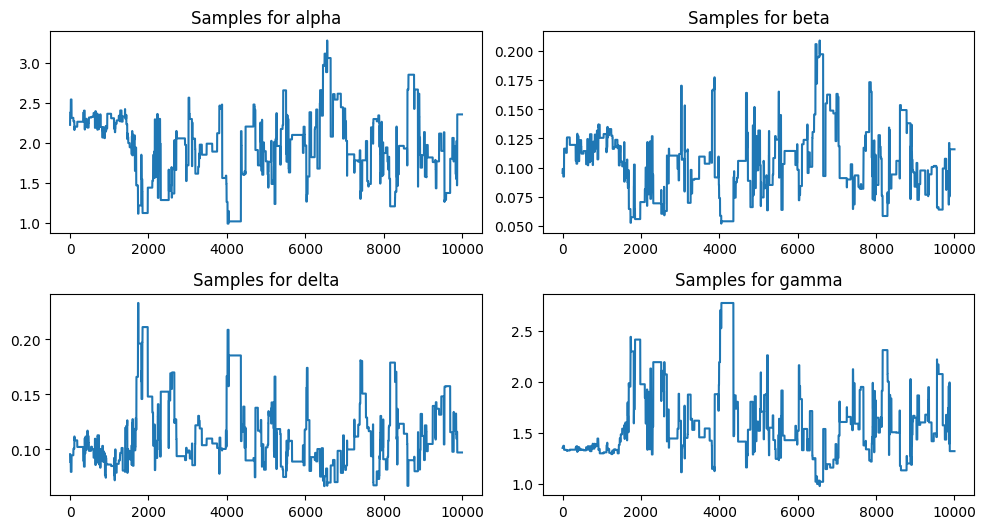

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5.4))
for i, param in enumerate(['alpha', 'beta', 'delta', 'gamma']):
    plt.subplot(2, 2, i + 1)
    plt.plot(np.exp(samples[:, i]))
    plt.title(f'Samples for {param}')
plt.tight_layout()
plt.show()



In [ ]:
i=2000
q2=np.quantile(samples[i:,:],0.5,axis=0)
q1=np.quantile(samples[i:,:],0.05,axis=0)
q3=np.quantile(samples[i:,:],0.95,axis=0)

In [ ]:
print(np.exp(q1),np.exp(q2),np.exp(q3))

[1.20691597 0.05853137 0.07469909 1.14198919] [1.89997897 0.09799437 0.10470127 1.54047915] [2.66674387 0.16302929 0.17864227 2.3098313 ]


[1.89997897 0.09799437 0.10470127 1.54047915]


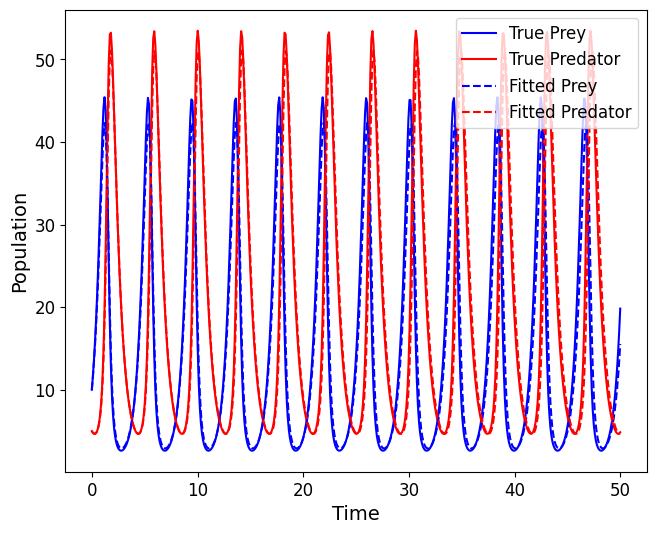

In [ ]:
# Plot the fitted model vs true data
#best_params = samples[np.argmax([log_likelihood(p, t, data, initial_conditions) for p in samples])]
fitted_model = generate_synthetic_data(np.exp(q2), initial_conditions, t)
print(np.exp(q2))
plt.figure(figsize=(7.5,6))
plt.plot(t, data[:, 0], 'b-', label='True Prey')
plt.plot(t, data[:, 1], 'r-', label='True Predator')
plt.plot(t, fitted_model[:, 0], 'b--', label='Fitted Prey')
plt.plot(t, fitted_model[:, 1], 'r--', label='Fitted Predator')
plt.legend(fontsize=12)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Population',fontsize=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('nonsense.pdf')
plt.show()